In [5]:
import numpy as np
import torch
from keymorph.keypoint_aligners import TPS

class ApproximateTPS(TPS):
    """Method 2 from ``Approximate TPS Mappings'' by Donato and Belongie"""

    def fit(self, c, lmbda, subsample_indices, w=None):
        """Assumes last dimension of c contains target points.

          Set up and solve linear system:
            [K + lmbda*I   P] [w] = [v]
            [        P^T   0] [a]   [0]

          If w is provided, solve weighted TPS:
            [K + lmbda*1/diag(w)   P] [w] = [v]
            [                P^T   0] [a]   [0]

          See https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=929618&tag=1, Eq. (8)
        Args:
          c: control points and target point (bs, T, d+1)
          lmbda: Lambda values per batch (bs)
        """
        device = c.device
        bs, T = c.shape[0], c.shape[1]
        ctrl, tgt = c[:, :, : self.dim], c[:, :, -1]
        num_subsample = len(subsample_indices)

        # Build K matrix
        U = TPS.u(TPS.d(ctrl, ctrl[:, subsample_indices]))
        if w is not None:
            print(w.shape)
            w = torch.diag_embed(w)
            print(w.shape)
            w = w[:, :, subsample_indices]
            K = U + torch.reciprocal(w + 1e-6) * lmbda.view(
                bs, 1, 1
            )  # w are weights, TPS expects variances
        else:
            I = torch.eye(T).repeat(bs, 1, 1).float().to(device)
            I = I[:, :, subsample_indices]
            K = U + I * lmbda.view(bs, 1, 1)

        # Build P matrix
        P = torch.ones((bs, T, self.dim + 1)).float()
        P[:, :, 1:] = ctrl
        P_tilde = P[:, subsample_indices]

        # Build v vector
        v = torch.zeros(bs, T + self.dim + 1).float()
        v[:, :T] = tgt

        A = torch.zeros((bs, T + self.dim + 1, num_subsample + self.dim + 1)).float()
        A[:, :T, :num_subsample] = K
        A[:, :T, -(self.dim + 1) :] = P
        A[:, -(self.dim + 1) :, :num_subsample] = P_tilde.transpose(1, 2)

        return torch.linalg.lstsq(A, v).solution

    def tps_theta_from_points(
        self, c_src, c_dst, lmbda, subsample_indices, weights=None
    ):
        """
        Args:
          c_src: (bs, T, dim)
          c_dst: (bs, T, dim)
          lmbda: (bs)
        """
        device = c_src.device

        cx = torch.cat((c_src, c_dst[..., 0:1]), dim=-1)
        cy = torch.cat((c_src, c_dst[..., 1:2]), dim=-1)
        if self.dim == 3:
            cz = torch.cat((c_src, c_dst[..., 2:3]), dim=-1)

        theta_dx = self.fit(cx, lmbda, subsample_indices, w=weights).to(device)
        theta_dy = self.fit(cy, lmbda, subsample_indices, w=weights).to(device)
        if self.dim == 3:
            theta_dz = self.fit(cz, lmbda, subsample_indices, w=weights).to(device)

        if self.dim == 3:
            return torch.stack((theta_dx, theta_dy, theta_dz), -1)
        else:
            return torch.stack((theta_dx, theta_dy), -1)

    def grid_from_points(
        self,
        points_m,
        points_f,
        grid_shape,
        subsample_indices,
        weights=None,
        compute_on_subgrids=False,
        **kwargs,
    ):
        lmbda = kwargs["lmbda"]

        assert len(subsample_indices) < points_m.shape[1]
        theta = self.tps_theta_from_points(
            points_f,
            points_m,
            lmbda,
            subsample_indices,
            weights=weights,
        )
        return self.tps_grid(
            theta,
            points_f[:, subsample_indices],
            grid_shape,
            compute_on_subgrids=compute_on_subgrids,
        )

    def points_from_points(
        self, ctl_points, tgt_points, points, subsample_indices, weights=None, **kwargs
    ):
        lmbda = kwargs["lmbda"]
        theta = self.tps_theta_from_points(
            ctl_points,
            tgt_points,
            lmbda,
            weights=weights,
            subsample_indices=subsample_indices,
        )
        return self.deform_points(theta, ctl_points[:, subsample_indices], points)

In [6]:
import keymorph.utils as utils
import matplotlib.pyplot as plt
from keymorph.cm_plotter import show_img_and_points

img_m = '/midtier/sablab/scratch/alw4013/keymorph/experiments/truncatedunet1/__eval__gigamed-weighted-ACTUALLYWEIGHTED-earlystopsubjects10-withharddiceroi-lesion-normal-skullstrip-nonskullstrip-128_datasetgigamed_modelkeymorph_keypoints128_batch1_normTypeinstance_lr3e-06/eval/ss_unimodal/0_1_nnUNet_1mmiso_256x256x256_MNI_HD-BET_preprocessed-Dataset5083_IXIT1_nnUNet_1mmiso_256x256x256_MNI_HD-BET_preprocessed-Dataset5083_IXIT1/img_m_1-nnUNet_1mmiso_256x256x256_MNI_HD-BET_preprocessed-Dataset5083_IXIT1-rot0.npy'
img_f = '/midtier/sablab/scratch/alw4013/keymorph/experiments/truncatedunet1/__eval__gigamed-weighted-ACTUALLYWEIGHTED-earlystopsubjects10-withharddiceroi-lesion-normal-skullstrip-nonskullstrip-128_datasetgigamed_modelkeymorph_keypoints128_batch1_normTypeinstance_lr3e-06/eval/ss_unimodal/0_1_nnUNet_1mmiso_256x256x256_MNI_HD-BET_preprocessed-Dataset5083_IXIT1_nnUNet_1mmiso_256x256x256_MNI_HD-BET_preprocessed-Dataset5083_IXIT1/img_f_0-nnUNet_1mmiso_256x256x256_MNI_HD-BET_preprocessed-Dataset5083_IXIT1.npy'
img_a = '/midtier/sablab/scratch/alw4013/keymorph/experiments/truncatedunet1/__eval__gigamed-weighted-ACTUALLYWEIGHTED-earlystopsubjects10-withharddiceroi-lesion-normal-skullstrip-nonskullstrip-128_datasetgigamed_modelkeymorph_keypoints128_batch1_normTypeinstance_lr3e-06/eval/ss_unimodal/0_1_nnUNet_1mmiso_256x256x256_MNI_HD-BET_preprocessed-Dataset5083_IXIT1_nnUNet_1mmiso_256x256x256_MNI_HD-BET_preprocessed-Dataset5083_IXIT1/img_a_0-nnUNet_1mmiso_256x256x256_MNI_HD-BET_preprocessed-Dataset5083_IXIT1_1-nnUNet_1mmiso_256x256x256_MNI_HD-BET_preprocessed-Dataset5083_IXIT1-rot0-affine.npy'
points_m = '/midtier/sablab/scratch/alw4013/keymorph/experiments/truncatedunet1/__eval__gigamed-weighted-ACTUALLYWEIGHTED-earlystopsubjects10-withharddiceroi-lesion-normal-skullstrip-nonskullstrip-128_datasetgigamed_modelkeymorph_keypoints128_batch1_normTypeinstance_lr3e-06/eval/ss_unimodal/0_1_nnUNet_1mmiso_256x256x256_MNI_HD-BET_preprocessed-Dataset5083_IXIT1_nnUNet_1mmiso_256x256x256_MNI_HD-BET_preprocessed-Dataset5083_IXIT1/points_m_1-nnUNet_1mmiso_256x256x256_MNI_HD-BET_preprocessed-Dataset5083_IXIT1-rot0.npy'
points_f = '/midtier/sablab/scratch/alw4013/keymorph/experiments/truncatedunet1/__eval__gigamed-weighted-ACTUALLYWEIGHTED-earlystopsubjects10-withharddiceroi-lesion-normal-skullstrip-nonskullstrip-128_datasetgigamed_modelkeymorph_keypoints128_batch1_normTypeinstance_lr3e-06/eval/ss_unimodal/0_1_nnUNet_1mmiso_256x256x256_MNI_HD-BET_preprocessed-Dataset5083_IXIT1_nnUNet_1mmiso_256x256x256_MNI_HD-BET_preprocessed-Dataset5083_IXIT1/points_f_0-nnUNet_1mmiso_256x256x256_MNI_HD-BET_preprocessed-Dataset5083_IXIT1.npy'
points_a = '/midtier/sablab/scratch/alw4013/keymorph/experiments/truncatedunet1/__eval__gigamed-weighted-ACTUALLYWEIGHTED-earlystopsubjects10-withharddiceroi-lesion-normal-skullstrip-nonskullstrip-128_datasetgigamed_modelkeymorph_keypoints128_batch1_normTypeinstance_lr3e-06/eval/ss_unimodal/0_1_nnUNet_1mmiso_256x256x256_MNI_HD-BET_preprocessed-Dataset5083_IXIT1_nnUNet_1mmiso_256x256x256_MNI_HD-BET_preprocessed-Dataset5083_IXIT1/points_a_0-nnUNet_1mmiso_256x256x256_MNI_HD-BET_preprocessed-Dataset5083_IXIT1_1-nnUNet_1mmiso_256x256x256_MNI_HD-BET_preprocessed-Dataset5083_IXIT1-rot0-affine.npy'
points_weights = '/midtier/sablab/scratch/alw4013/keymorph/experiments/truncatedunet1/__eval__gigamed-weighted-ACTUALLYWEIGHTED-earlystopsubjects10-withharddiceroi-lesion-normal-skullstrip-nonskullstrip-128_datasetgigamed_modelkeymorph_keypoints128_batch1_normTypeinstance_lr3e-06/eval/ss_unimodal/0_1_nnUNet_1mmiso_256x256x256_MNI_HD-BET_preprocessed-Dataset5083_IXIT1_nnUNet_1mmiso_256x256x256_MNI_HD-BET_preprocessed-Dataset5083_IXIT1/points_weights_0-nnUNet_1mmiso_256x256x256_MNI_HD-BET_preprocessed-Dataset5083_IXIT1_1-nnUNet_1mmiso_256x256x256_MNI_HD-BET_preprocessed-Dataset5083_IXIT1-rot0-affine.npy'

device = 'cuda'

img_m = torch.tensor(np.load(img_m)[None]).to(device)
img_f = torch.tensor(np.load(img_f)[None]).to(device)
# img_a = np.load(img_a)

points_m = torch.tensor(np.load(points_m)[None]).to(device)
points_f = torch.tensor(np.load(points_f)[None]).to(device)
points_a = np.load(points_a)[None]
weights = torch.tensor(np.load(points_weights))[None].to(device)
print(img_f.shape, points_m.shape, points_f.shape, weights.shape)

torch.Size([1, 1, 256, 256, 256]) torch.Size([1, 128, 3]) torch.Size([1, 128, 3]) torch.Size([1, 128])


In [7]:
# keypoints_subsample_indices = np.arange(32)
keypoints_subsample_indices = np.random.choice(
                128, size=32, replace=False
                )
print(keypoints_subsample_indices)
lmbda = torch.tensor(10.).to(device)

approx_tps = ApproximateTPS(dim=3)
grid = approx_tps.grid_from_points(points_m, 
                                   points_f, 
                                   img_f.shape, 
                                   subsample_indices=keypoints_subsample_indices, 
                                   lmbda=lmbda,
                                   weights=weights)
points_a = approx_tps.points_from_points(points_m, points_f, points_m, subsample_indices=keypoints_subsample_indices, lmbda=lmbda)

print(((points_f - points_a)**2).sum())

img_a = utils.align_img(grid, img_m)

[ 84 120 108  93  81  88   5  27  14  72 116  44  64  82  26   3   0  73
   1  43  38  36   8 112  49 100 121  60  45  92 118  28]
torch.Size([1, 128])
torch.Size([1, 128, 128])
torch.Size([1, 128])
torch.Size([1, 128, 128])
torch.Size([1, 128])
torch.Size([1, 128, 128])
tensor(0.0117, device='cuda:0')


(1, 128) (1, 128, 3)
(1, 128) (128,)
(1, 128) (1, 128, 3)
(1, 128) (128,)
(2, 128) (2, 128, 3)
(2, 128) (128,)
(2, 128) (128,)


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

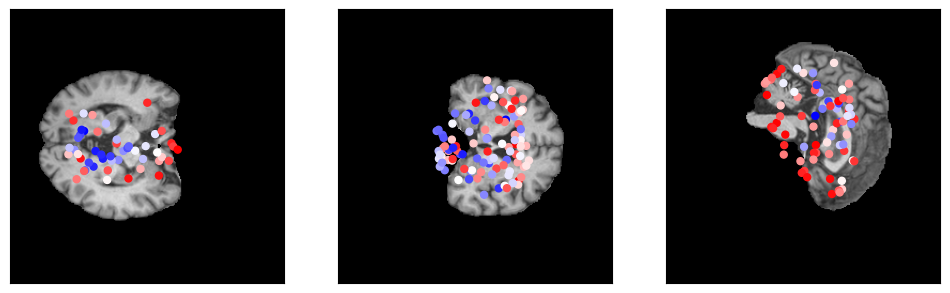

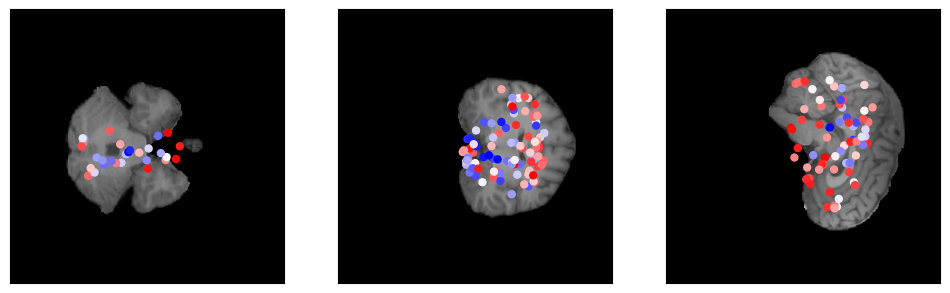

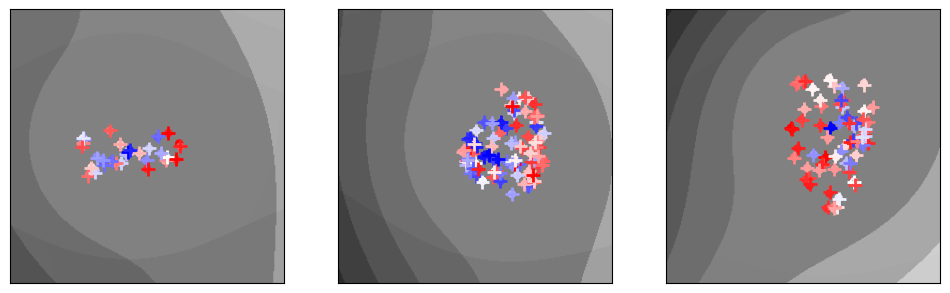

In [8]:
show_img_and_points(img_m[0, 0].cpu().numpy(), points_m[0].cpu().numpy())
show_img_and_points(img_f[0, 0].cpu().numpy(), points_f[0].cpu().numpy())
show_img_and_points(img_a[0, 0].cpu().numpy(), torch.cat((points_a, points_f), dim=0).cpu().numpy())